## Week 1

- calculate performance metrics of the model output compared to the truth values 

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("darkgrid")

In [2]:
df = pd.read_csv("helena_results.csv")
df.head()

,file,x1,x2,y1,y2,mask,date,start_time,frame no,quadrant,true_mask
0,park-tests/converted/coverted_FRAMES/20210526_...,720,763,185,246,0,20210526,182313,1248,3,0
1,park-tests/converted/coverted_FRAMES/20210526_...,13,40,3,40,1,20210526,182313,4876,3,1
2,park-tests/converted/coverted_FRAMES/20210526_...,695,736,201,254,0,20210526,182313,4876,3,0
3,park-tests/converted/coverted_FRAMES/20210526_...,573,663,326,430,1,20210526,182313,4397,1,1
4,park-tests/converted/coverted_FRAMES/20210526_...,893,973,346,452,1,20210526,182313,4397,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file        1038 non-null   object
 1   x1          1038 non-null   int64 
 2   x2          1038 non-null   int64 
 3   y1          1038 non-null   int64 
 4   y2          1038 non-null   int64 
 5   mask        1038 non-null   int64 
 6   date        1038 non-null   int64 
 7   start_time  1038 non-null   int64 
 8   frame no    1038 non-null   int64 
 9   quadrant    1038 non-null   int64 
 10  true_mask   1038 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 89.3+ KB


### Definitions
mask: model output

true_mask: true label (human labeled)

- 0: mask
- 1: no mask
- 2: false detection

A false detection describes an instance where the model detected the ground, or other object, as a face.

In [4]:
df['mask'].value_counts()

0    707
1    331
Name: mask, dtype: int64

In [5]:
df['true_mask'].value_counts()

1    530
0    447
2     61
Name: true_mask, dtype: int64

### Metrics and Scoring

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# exclude false detections from this analysis
df_filtered = df[df['true_mask'] < 2]

df_filtered.shape

(977, 11)

In [7]:
# store the true and predicted labels into variables for metric calculations
mask_true = df_filtered['true_mask']
mask_pred = df_filtered['mask']

In [8]:
def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp/(tp+fn)

def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn/(tn+fp)

In [9]:
metric_functions = {'sensitivity': sensitivity, 
                    'specificity': specificity,
                    'accuracy': accuracy_score, 
                    'precision': precision_score,
                    'recall': recall_score,
                    'f1': f1_score}

metric_values = {}

for metric in metric_functions:
    score = metric_functions[metric](y_true=mask_true, y_pred=mask_pred)
    print(f'{metric} score: {round(score, 4)}')
    metric_values[metric] = round(score, 4)

sensitivity score: 0.4302
specificity score: 0.7987
accuracy score: 0.5988
precision score: 0.717
recall score: 0.4302
f1 score: 0.5377


## Week 2

- calculating confidence intervals around these numbers
- two sample testing of accuracy metrics - testing specificity between different groups, p values 
- looking at different groups where the metrics are better/worse
    - look for big spreads
    
- Nirmal - worked with Ted
- Ted Morris (camera / robotics, etc)
    - Camera has object detection capabilities
- Helena - worked with Catherine Zhao
    - Graduated and developed NN
    
- Catherine Zhao
    - Reach out to Catherine for training data / model code
    - Hoping to get access to the code / training data
    - Willing to put them on github with prof wolfson

#### Exploration

- explore rnn for image classification since it has a memory component and looks at multiple frames at once

### Calculating confidence intervals around the metrics

#### Z-score

In [10]:
def confidence_interval_z_score(n, metric):
    # standard error
    se = np.sqrt(metric * (1-metric) / n)
    
    # z score for 95% confidence interval
    z = stats.norm.ppf(0.975)
    
    lower = metric - z*se
    upper = metric + z*se
    
    return (round(lower, 4), round(upper, 4))

In [11]:
n = df.shape[0]
for metric in metric_values:
    metric_value = metric_values[metric]
    ci = confidence_interval_z_score(n, metric_value)
    print(f'95% confidence interval for the {metric} of {metric_value} is: {ci} \n')

95% confidence interval for the sensitivity of 0.4302 is: (0.4001, 0.4603) 

95% confidence interval for the specificity of 0.7987 is: (0.7743, 0.8231) 

95% confidence interval for the accuracy of 0.5988 is: (0.569, 0.6286) 

95% confidence interval for the precision of 0.717 is: (0.6896, 0.7444) 

95% confidence interval for the recall of 0.4302 is: (0.4001, 0.4603) 

95% confidence interval for the f1 of 0.5377 is: (0.5074, 0.568) 



#### Turns out, using the z score method for some metrics may not be adequate

Since the denominator is n, the number of records. This will work for something like the average (since the denominator is the same), but for metrics like specificity and sensitivity, the denominator isn't - so a method like bootstrapping will work better.

#### Bootstrapping

In [12]:
from sklearn.utils import resample

def confidence_interval_bootstrapping(y_true, y_pred, metric_function, n_iterations=100, alpha=0.05):
    
    metric_samples = []
    
    for i in range(n_iterations):
        y_true_resample, y_pred_resample = resample(y_true, y_pred)
        metric_resample = metric_function(y_true_resample, y_pred_resample)
        metric_samples.append(metric_resample)
        
    lower = np.percentile(metric_samples, alpha/2*100)
    upper = np.percentile(metric_samples, (1-alpha/2)*100)
    
    return (round(lower, 4), round(upper, 4))

def get_bootstrapping_ci(df):
    
    mask_true = df['true_mask']
    mask_pred = df['mask']
    
    metrics_ci = {'Metric': [],
              'Score': [],
              'Lower bound': [],
              'Upper bound': []}
    
    metric_functions = {'sensitivity': sensitivity, 
                    'specificity': specificity,
                    'accuracy': accuracy_score, 
                    'precision': precision_score,
                    'recall': recall_score,
                    'f1': f1_score}

    metric_values = {}

    for metric in metric_functions:
        metrics_ci['Metric'].append(metric)

        metric_value = metric_functions[metric](y_true=mask_true, y_pred=mask_pred)
        metrics_ci['Score'].append(round(metric_value, 4))

        ci = confidence_interval_bootstrapping(mask_true, mask_pred, metric_functions[metric])
        metrics_ci['Lower bound'].append(ci[0])
        metrics_ci['Upper bound'].append(ci[1])
    
    return pd.DataFrame(metrics_ci)
    
    

In [13]:
metrics_df = get_bootstrapping_ci(df_filtered)
metrics_df['df'] = 'All'
metrics_df

,Metric,Score,Lower bound,Upper bound,df
0,sensitivity,0.4302,0.3801,0.4654,All
1,specificity,0.7987,0.7656,0.8330,All
2,accuracy,0.5988,0.5715,0.6239,All
3,precision,0.7170,0.6734,0.7641,All
4,recall,0.4302,0.3934,0.4735,All
5,f1,0.5377,0.5035,0.5753,All


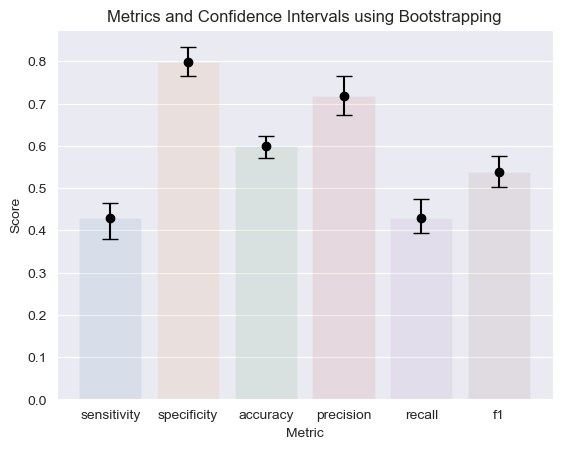

In [14]:
# plt.figure(figsize=(10,6))

sns.barplot(data=metrics_df, x='Metric', y='Score', alpha=0.1)
y_error = (metrics_df['Score']-metrics_df['Lower bound'], metrics_df['Upper bound']-metrics_df['Score'])
plt.errorbar(x=metrics_df.index, y=metrics_df['Score'], yerr=y_error, fmt='o', ecolor='black', color='black', capsize=6)

plt.title("Metrics and Confidence Intervals using Bootstrapping")
plt.show()

## Week 3
- look into bootstrap pros and cons
- get this in a table for now
- for future - look at sub groups - plot on same plot
- for now, stick with things like sensitivity and specificity since they don't depend on prevalance of the event\
- meet with ted and nermel

### Sub Groups

In [15]:
df['quadrant'].value_counts()

1    542
3    457
4     27
2     12
Name: quadrant, dtype: int64

#### Most bounding boxes in quadrants 1 and 3

In [16]:
pd.crosstab(df['mask'], df['quadrant'], margins=True, margins_name='Total')

quadrant,1,2,3,4,Total
mask,,,,,
0,315,8,363,21,707
1,227,4,94,6,331
Total,542,12,457,27,1038


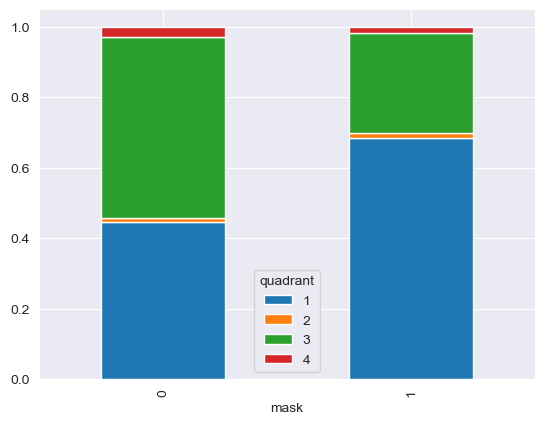

In [17]:
pd.crosstab(df['mask'], df['quadrant'], normalize='index').plot.bar(stacked=True)
plt.show()

#### Most mask detections were found in quadrant 3

- Quadrant 3 contains 457/1038 ~ 44% of the records

In [18]:
df_q3 = df_filtered[df_filtered['quadrant'] == 3]

In [19]:
metrics_df_q3 = get_bootstrapping_ci(df_q3)
metrics_df_q3['df'] = 'Q3'
metrics_df_q3

,Metric,Score,Lower bound,Upper bound,df
0,sensitivity,0.1786,0.1090,0.2787,Q3
1,specificity,0.7827,0.7536,0.8113,Q3
2,accuracy,0.6682,0.6218,0.7010,Q3
3,precision,0.1613,0.0937,0.2228,Q3
4,recall,0.1786,0.0827,0.2619,Q3
5,f1,0.1695,0.1014,0.2339,Q3


#### Comparing the metric scores between q3 and all quadrants

In [20]:
df_concat = pd.concat([metrics_df, metrics_df_q3], ignore_index=True)

In [24]:
df_accuracies = df_concat[df_concat['Metric'] == 'accuracy']
df_accuracies.reset_index(inplace=True)
df_accuracies

,index,Metric,Score,Lower bound,Upper bound,df
0,2,accuracy,0.5988,0.5715,0.6239,All
1,8,accuracy,0.6682,0.6218,0.7010,Q3


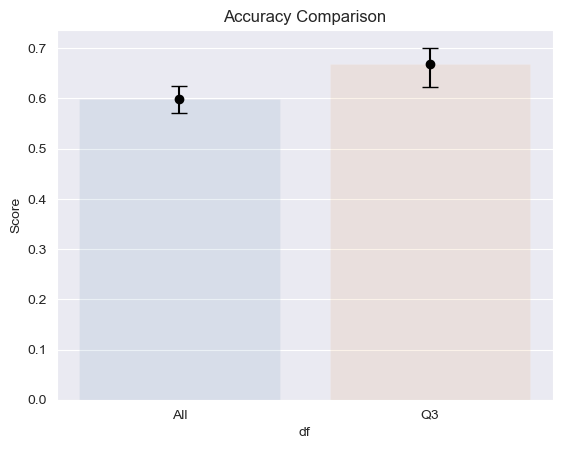

In [35]:
sns.barplot(data=df_accuracies, x='df', y='Score', alpha=0.1)
y_error = (df_accuracies['Score']-df_accuracies['Lower bound'], df_accuracies['Upper bound']-df_accuracies['Score'])
plt.errorbar(x=df_accuracies.index, y=df_accuracies['Score'], yerr=y_error, fmt='o', ecolor='black', color='black', capsize=6)

plt.title("Accuracy Comparison")
plt.show()